In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

import os
import string
import json
import optuna

import Utils as ut
all_params=["Dropout","Regularisation\nweight", "Norm\nexponent","Learning\nrate","Weight\ndecay"]
palette = {all_params[i] : ut.colors_to_use_bright[::-1][i] for i in range(len(all_params))} 
%matplotlib inline

# HPO TAE

In [ ]:
datasets=["Kidney","10XhsBrain3kMO", "10XhsBrain3kMO", "MouseBrain","10XhsPBMC10kMO", "10XhsPBMC10kMO"]
featurespaces=["Peak","Peak", "GEX", "Peak", "Peak", "GEX"]
jobs=["BrP", "BrG", "KiP", "PbP", "PbG", "MbP"]

In [ ]:
for dataset, featurespace, job in zip(datasets, featurespaces, jobs):
	matrix=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_QC.h5ad"
	name=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/HPO/TAE/{dataset}_{featurespace}_HPO_TAE"
	os.system(f"mkdir -p Datasets/{dataset}/FeatureSpaces/{featurespace}/HPO/TAE")
	os.system(f"sbatch -p slim18 -J HTopo{job} --mem=64G --ntasks=1 --cpus-per-task=10 --exclusive \
			  /store24/project24/ladcol_012/GNN/Run_HPO.sh {matrix} {name} TAE")

In [18]:
import optuna

storage = "sqlite:///Datasets/Kidney/FeatureSpaces/Peak/HPO/TAE/Kidney_Peak_HPO_TAE.db"
print(optuna.get_all_study_names(storage=storage))

['Kidney/Peak/HPO/TopoAE/Kidney_Peak_HPO_TopoAE']


## SEAGALL_SuppFig15_Up

In [19]:
datasets=["Kidney","10XhsBrain3kMO", "10XhsBrain3kMO", "MouseBrain","10XhsPBMC10kMO", "10XhsPBMC10kMO"]
names=["Kidney","Human brain","Human brain", "Mouse brain", "PBMC","PBMC"]
featurespaces=["Peak","Peak", "GEX", "Peak", "Peak", "GEX"]
studies={}
studies = {}
for dataset, feats_space, n in zip(datasets, featurespaces, names):

    db_path = f"Datasets/{dataset}/FeatureSpaces/{feats_space}/HPO/TAE/{dataset}_{feats_space}_HPO_TAE.db"
    storage = f"sqlite:///{db_path}"
    study_name = f"{dataset}/{feats_space}/HPO/TopoAE/{dataset}_{feats_space}_HPO_TopoAE"
    key = f"{n} - {'Peaks' if feats_space=='Peak' else feats_space}"
    studies[key] = optuna.load_study(study_name=study_name,storage=storage)
    
df=pd.DataFrame(columns=["Parameter","Value","Importance", "Dataset"])
order=["lam","p","dp","lr","weight_decay"]
for p in order:
	values=[np.log10(studies[key].best_params[p]) for key in studies.keys()]
	weights=[optuna.importance.get_param_importances(studies[key])[p] for key in studies.keys()]
	d=pd.DataFrame(data=[values, weights], index=["Value","Importance"]).T
	d["Dataset"]=studies.keys()
	d["Parameter"]=p
	df=pd.concat([df,d])

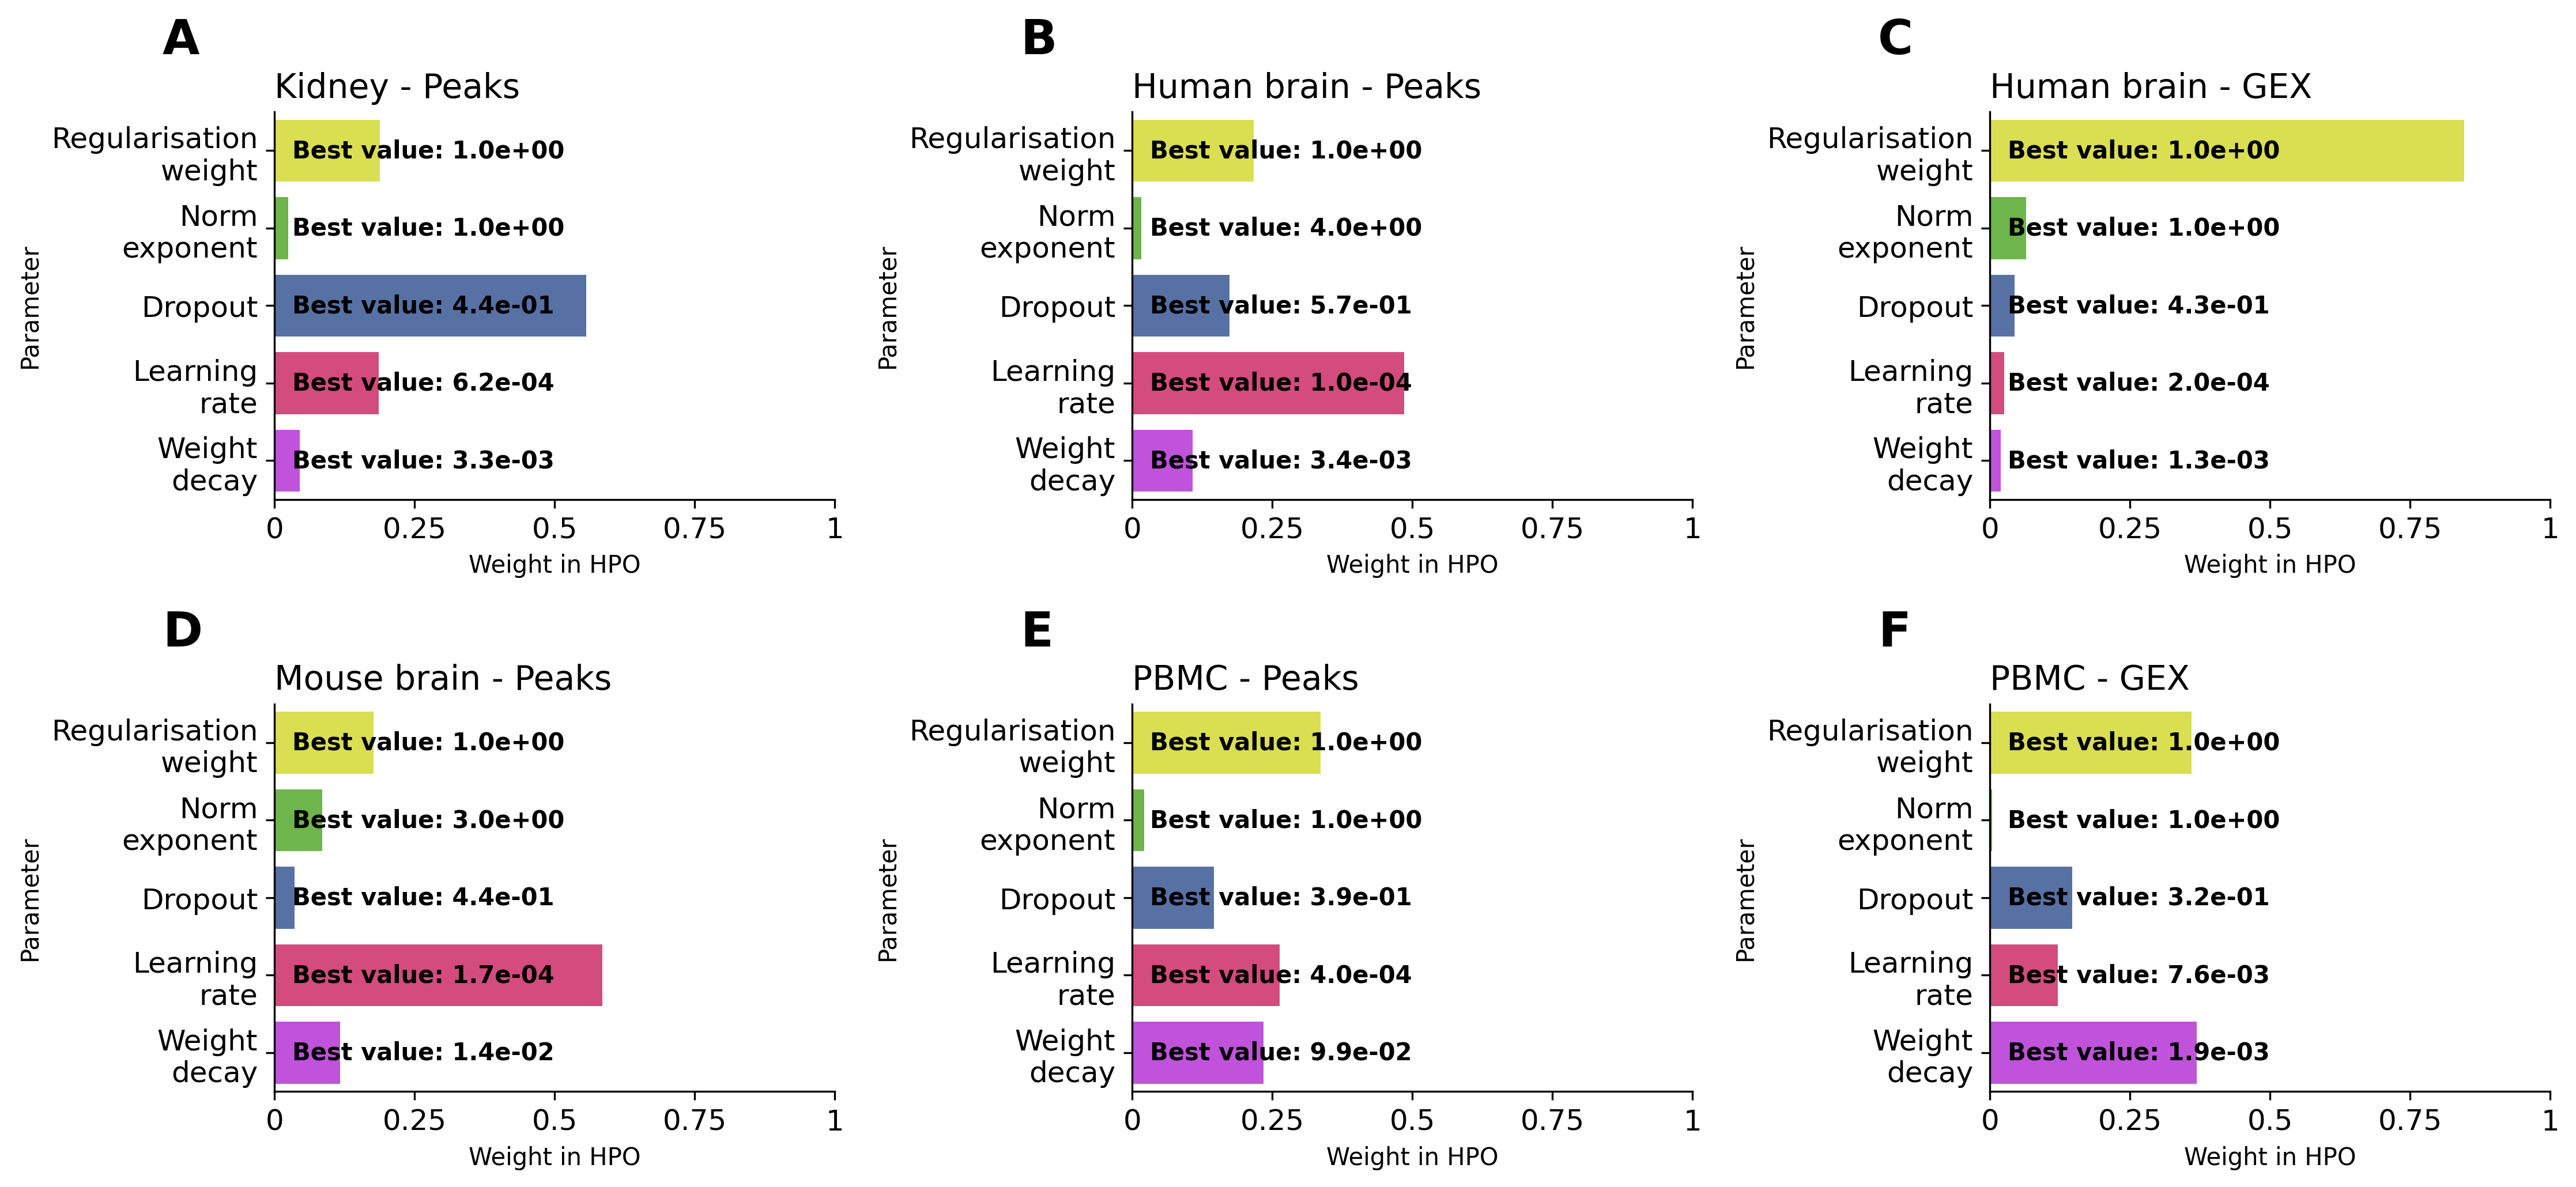

In [20]:
params = {'axes.labelsize': 10,
		 'axes.titlesize': 14,
		 'xtick.labelsize' : 12,
		 'ytick.labelsize': 12,
		 "lines.linewidth" : 4,
		 "figure.dpi" : 300,
		 "figure.figsize": [15, 7]}
plt.rcParams.update(params)
fig, axs=plt.subplots(2,3)
axs=axs.flatten()
yticks=["Regularisation\nweight", "Norm\nexponent", "Dropout","Learning\nrate","Weight\ndecay"]
subpalette=[palette[p] for p in yticks]
for ax, study in enumerate(studies.keys()):
	imp=optuna.importance.get_param_importances(studies[study])
	new_imp={key : imp[key] for key in order}
	d=pd.DataFrame.from_dict(new_imp, orient="index").reset_index().rename(columns={"index" : "Parameter", 0 : "Importance"})
	d["Importance"]=d["Importance"].astype(float)
	plots=sns.barplot(x=d["Importance"], y=d["Parameter"],palette=subpalette, ax=axs[ax])
	size=np.array([studies[study].best_params[key] for key in order], dtype="float32")
	for i, p in enumerate(plots.patches):
		plots.annotate("Best value: {:.1e}".format(size[i]), xy=(0.01, p.get_y()+p.get_height()/2),
				 xytext=(5, 0), textcoords='offset points', ha="left", va="center", size=10, weight="bold")
	axs[ax].set_xlim([0,1])
	axs[ax].set_yticks(axs[ax].get_yticks(), yticks)
	axs[ax].set_title(study, loc='left')
	axs[ax].spines['top'].set_visible(False)
	axs[ax].spines['right'].set_visible(False)
	axs[ax].text(-0.2, 1.15, string.ascii_uppercase[ax], transform=axs[ax].transAxes, size=20, weight='bold',rotation=0)	
	axs[ax].set_xticks([0, 0.25, 0.5, 0.75, 1], ["0", "0.25", "0.5", "0.75", "1"])
	axs[ax].set_xlabel("Weight in HPO")
	axs[ax].set_ylabel("Parameter")
		
plt.tight_layout(w_pad=1.3)
plt.savefig(f"Figures/SEAGALL_SuppFig15_Up.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

# HPO VAE

In [ ]:
datasets=["Kidney","10XhsBrain3kMO", "10XhsBrain3kMO", "MouseBrain","10XhsPBMC10kMO", "10XhsPBMC10kMO"]
featurespaces=["Peak","Peak", "GEX", "Peak", "Peak", "GEX"]
jobs=["BrP", "BrG", "KiP", "PbP", "PbG", "MbP"]

In [ ]:
for dataset, featurespace, job in zip(datasets, featurespaces, jobs):
	matrix=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_QC.h5ad"
	name=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/HPO/VAE/{dataset}_{featurespace}_HPO_VAE"
	os.system(f"mkdir -p Datasets/{dataset}/FeatureSpaces/{featurespace}/HPO/VAE")
	os.system(f"sbatch -p slim18 -J HVAE{job} --mem=64G --ntasks=1 --cpus-per-task=10 \
	/store24/project24/ladcol_012/GNN/Run_Exp.sh HPO_VAE {matrix} {name} VAE")

## SEAGALL_SuppFig15_Middle

In [21]:
datasets=["Kidney","10XhsBrain3kMO", "10XhsBrain3kMO", "MouseBrain","10XhsPBMC10kMO", "10XhsPBMC10kMO"]
names=["Kidney","Human brain","Human brain", "Mouse brain", "PBMC","PBMC"]
featurespaces=["Peak","Peak", "GEX", "Peak", "Peak", "GEX"]
studies={}
for dataset, feats_space, n in zip(datasets, featurespaces, names):
	name=f"Datasets/{dataset}/FeatureSpaces/{feats_space}/HPO/VAE/{dataset}_{feats_space}_HPO_VAE"
	storage_name = "sqlite:///{}.db".format(name) 
	if feats_space == "Peak":
		feats_space="Peaks"
	studies[f"{n} - {feats_space}"]=optuna.load_study(study_name=name, storage=storage_name)
df=pd.DataFrame(columns=["Parameter","Value","Importance", "Dataset"])
order=["dp","lr","weight_decay"]
for p in order:
	values=[np.log10(studies[key].best_params[p]) for key in studies.keys()]
	weights=[optuna.importance.get_param_importances(studies[key])[p] for key in studies.keys()]
	d=pd.DataFrame(data=[values, weights], index=["Value","Importance"]).T
	d["Dataset"]=studies.keys()
	d["Parameter"]=p
	df=pd.concat([df,d])

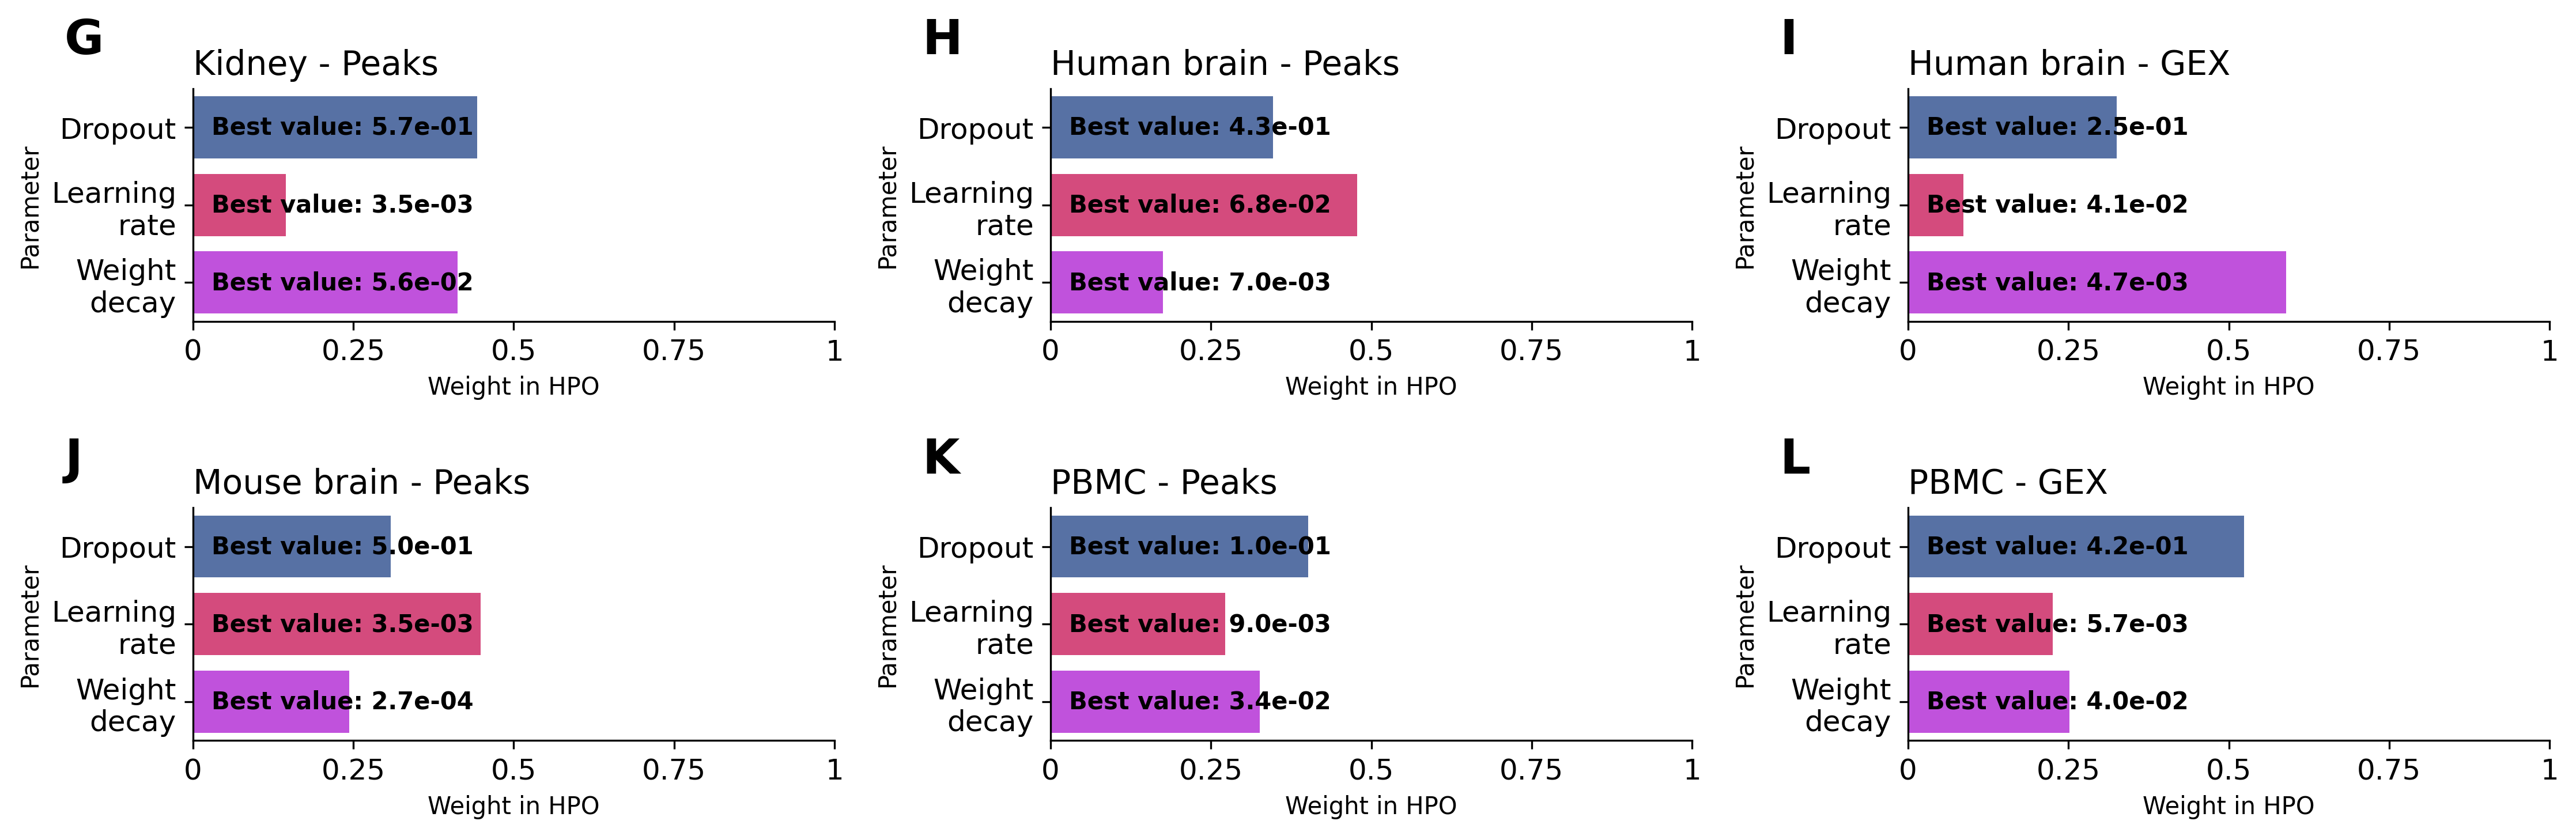

In [22]:
params = {'axes.labelsize': 10,
		 'axes.titlesize': 14,
		 'xtick.labelsize' : 12,
		 'ytick.labelsize': 12,
		 "lines.linewidth" : 4,
		 "figure.dpi" : 300,
		 "figure.figsize": [15, 5]}
plt.rcParams.update(params)
fig, axs=plt.subplots(2,3)
axs=axs.flatten()
yticks=["Dropout","Learning\nrate","Weight\ndecay"]
subpalette=[palette[p] for p in yticks]
for ax, study in enumerate(studies.keys()):
	imp=optuna.importance.get_param_importances(studies[study])
	new_imp={key : imp[key] for key in order}
	d=pd.DataFrame.from_dict(new_imp, orient="index").reset_index().rename(columns={"index" : "Parameter", 0 : "Importance"})
	d["Importance"]=d["Importance"].astype(float)
	plots=sns.barplot(x=d["Importance"], y=d["Parameter"],palette=subpalette, ax=axs[ax])
	size=np.array([studies[study].best_params[key] for key in order], dtype="float32")
	for i, p in enumerate(plots.patches):
		plots.annotate("Best value: {:.1e}".format(size[i]), xy=(0.01, p.get_y()+p.get_height()/2),
				 xytext=(5, 0), textcoords='offset points', ha="left", va="center", size=10, weight="bold")
	axs[ax].set_xlim([0,1])
	axs[ax].set_yticks(axs[ax].get_yticks(), yticks)
	axs[ax].set_title(study, loc='left')
	axs[ax].spines['top'].set_visible(False)
	axs[ax].spines['right'].set_visible(False)
	axs[ax].text(-0.2, 1.15, string.ascii_uppercase[ax+6], transform=axs[ax].transAxes, size=20, weight='bold',rotation=0)	
	axs[ax].set_xticks([0, 0.25, 0.5, 0.75, 1], ["0", "0.25", "0.5", "0.75", "1"])
	axs[ax].set_xlabel("Weight in HPO")
	axs[ax].set_ylabel("Parameter")
plt.tight_layout(w_pad=1.3)
plt.savefig(f"Figures/SEAGALL_SuppFig15_Middle.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

# HPO AE

In [ ]:
datasets=["Kidney","10XhsBrain3kMO", "10XhsBrain3kMO", "MouseBrain","10XhsPBMC10kMO", "10XhsPBMC10kMO"]
featurespaces=["Peak","Peak", "GEX", "Peak", "Peak", "GEX"]
jobs=["BrP", "BrG", "KiP", "PbP", "PbG", "MbP"]

In [ ]:
for dataset, featurespace, job in zip(datasets, featurespaces, jobs):
	matrix=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_QC.h5ad"
	name=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/HPO/AE/{dataset}_{featurespace}_HPO_AE"
	os.system(f"mkdir -p Datasets/{dataset}/FeatureSpaces/{featurespace}/HPO/AE")
	os.system(f"sbatch -p slim18 -J HAE{job} --mem=50G --ntasks=1 --cpus-per-task=8 \
	/store24/project24/ladcol_012/GNN/Run_Exp.sh HPO_AE {matrix} {name} AE")

## SEAGALL_SuppFig15_Down

In [23]:
datasets=["Kidney","10XhsBrain3kMO", "10XhsBrain3kMO", "MouseBrain","10XhsPBMC10kMO", "10XhsPBMC10kMO"]
names=["Kidney","Human brain","Human brain", "Mouse brain", "PBMC","PBMC"]
featurespaces=["Peak","Peak", "GEX", "Peak", "Peak", "GEX"]
studies={}
for dataset, feats_space, n in zip(datasets, featurespaces, names):
	print(dataset, feats_space, n)
	name=f"Datasets/{dataset}/FeatureSpaces/{feats_space}/HPO/AE/{dataset}_{feats_space}_HPO_AE"
	storage_name = "sqlite:///{}.db".format(name) 
	if feats_space == "Peak":
		feats_space="Peaks"
	studies[f"{n} - {feats_space}"]=optuna.load_study(study_name=name, storage=storage_name)
df=pd.DataFrame(columns=["Parameter","Value","Importance", "Dataset"])
order=["dp","lr","weight_decay"]
for p in order:
	values=[np.log10(studies[key].best_params[p]) for key in studies.keys()]
	weights=[optuna.importance.get_param_importances(studies[key])[p] for key in studies.keys()]
	d=pd.DataFrame(data=[values, weights], index=["Value","Importance"]).T
	d["Dataset"]=studies.keys()
	d["Parameter"]=p
	df=pd.concat([df,d])

Kidney Peak Kidney
10XhsBrain3kMO Peak Human brain
10XhsBrain3kMO GEX Human brain
MouseBrain Peak Mouse brain
10XhsPBMC10kMO Peak PBMC
10XhsPBMC10kMO GEX PBMC


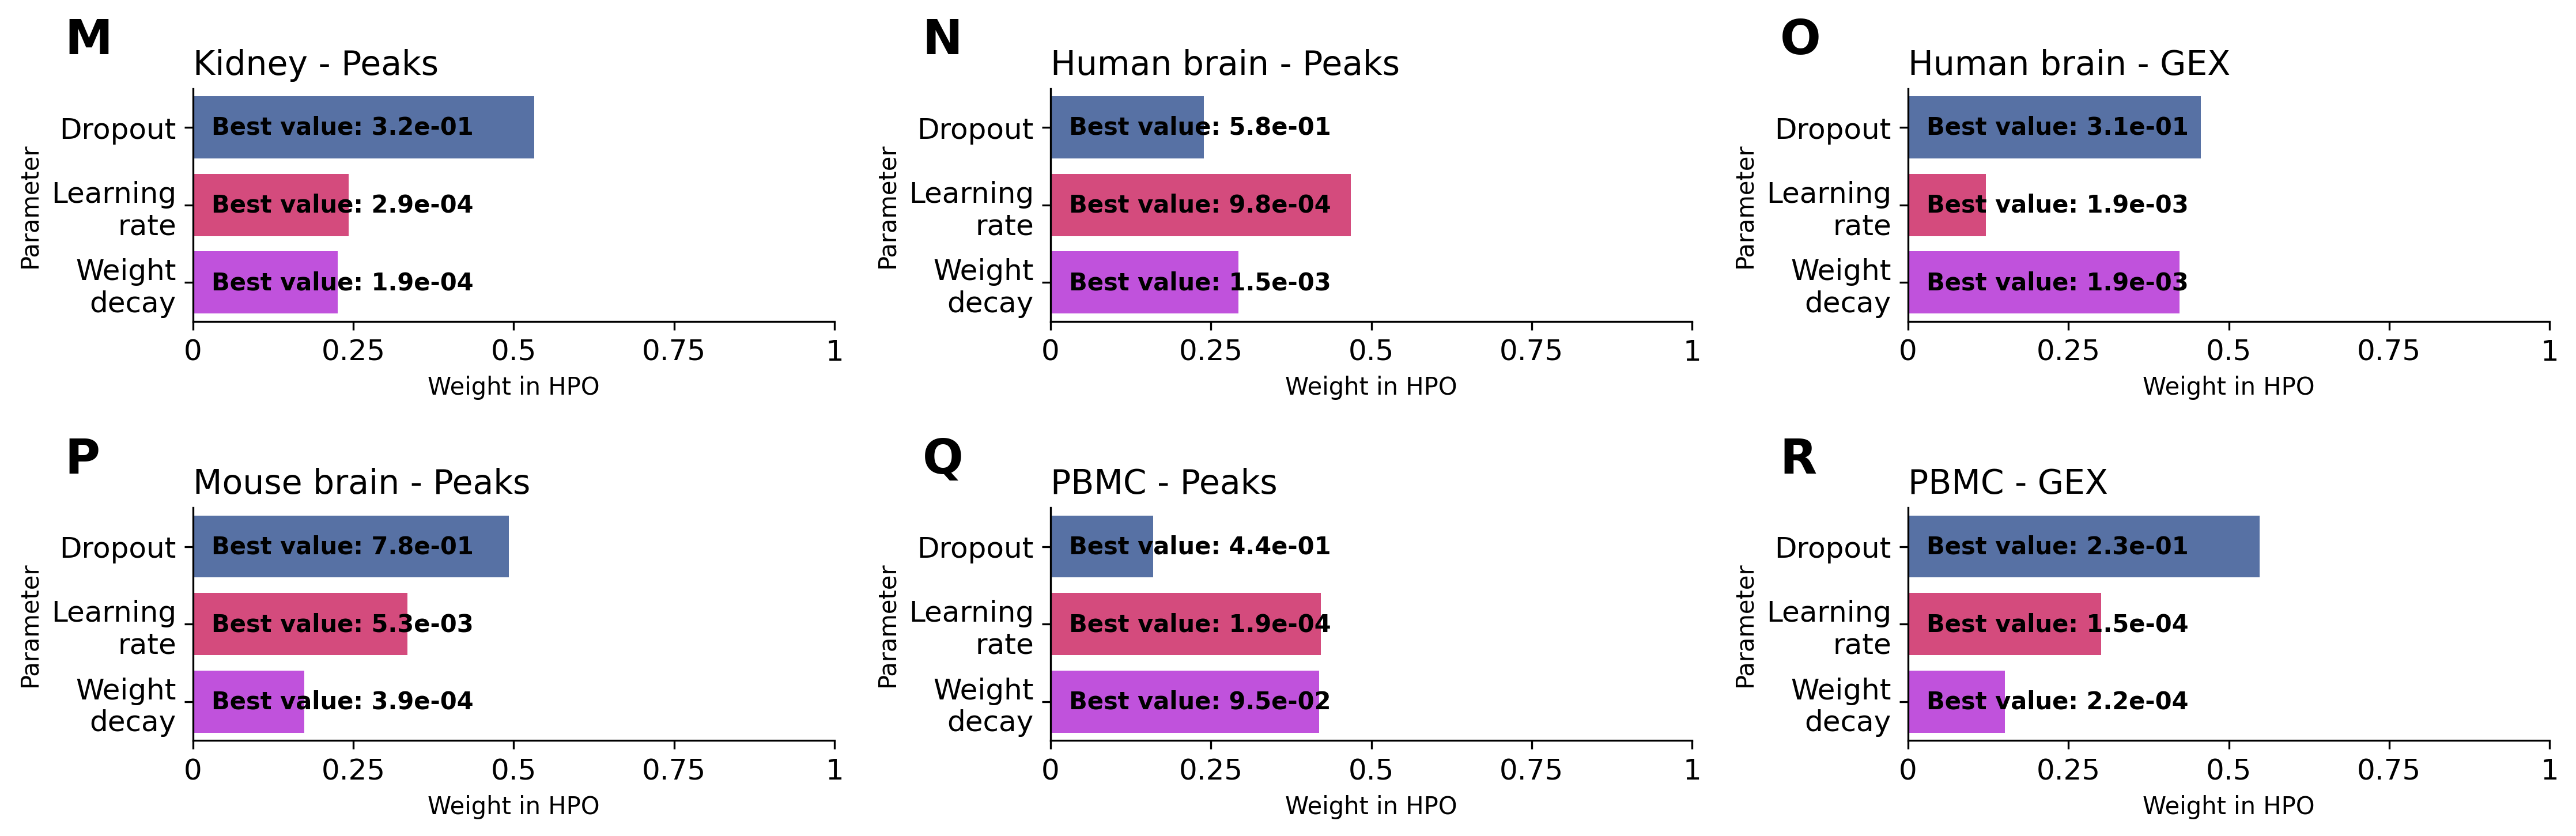

In [24]:
params = {'axes.labelsize': 10,
		 'axes.titlesize': 14,
		 'xtick.labelsize' : 12,
		 'ytick.labelsize': 12,
		 "lines.linewidth" : 4,
		 "figure.dpi" : 300,
		 "figure.figsize": [15, 5]}
plt.rcParams.update(params)
fig, axs=plt.subplots(2,3)
axs=axs.flatten()
yticks=["Dropout","Learning\nrate","Weight\ndecay"]
subpalette=[palette[p] for p in yticks]
for ax, study in enumerate(studies.keys()):
	imp=optuna.importance.get_param_importances(studies[study])
	new_imp={key : imp[key] for key in order}
	d=pd.DataFrame.from_dict(new_imp, orient="index").reset_index().rename(columns={"index" : "Parameter", 0 : "Importance"})
	d["Importance"]=d["Importance"].astype(float)
	plots=sns.barplot(x=d["Importance"], y=d["Parameter"],palette=subpalette, ax=axs[ax])
	size=np.array([studies[study].best_params[key] for key in order], dtype="float32")
	for i, p in enumerate(plots.patches):
		plots.annotate("Best value: {:.1e}".format(size[i]), xy=(0.01, p.get_y()+p.get_height()/2),
				 xytext=(5, 0), textcoords='offset points', ha="left", va="center", size=10, weight="bold")
	axs[ax].set_xlim([0,1])
	axs[ax].set_yticks(axs[ax].get_yticks(), yticks)
	axs[ax].set_title(study, loc='left')
	axs[ax].spines['top'].set_visible(False)
	axs[ax].spines['right'].set_visible(False)
	axs[ax].text(-0.2, 1.15, string.ascii_uppercase[ax+12], transform=axs[ax].transAxes, size=20, weight='bold',rotation=0)	
	axs[ax].set_xticks([0, 0.25, 0.5, 0.75, 1], ["0", "0.25", "0.5", "0.75", "1"])
	axs[ax].set_xlabel("Weight in HPO")
	axs[ax].set_ylabel("Parameter")
plt.tight_layout(w_pad=1.3)
plt.savefig(f"Figures/SEAGALL_SuppFig15_Down.png", format="png", dpi=300, bbox_inches='tight')
plt.show()